<h2>Finding Ghosts</h2>
<h2>Traccar 테스트 데이터 분석 - 데이터 수집량을 중심으로</h2>
<p>In theory, our tester's Traccar clients are supposed to send position data at every minutes. In fact, there is a delay of few seconds, practically. This is acceptable. However, we found that some clients didn't send data about a 3-6 hours.</p>
<p>We have to figure out why.</p>
<p>일부 환경에서 Traccar 가 오랜 기간 (몇 시간) 동안 데이터를 송신하지 않는 현상을 확인해야 한다.
주로 아이폰에서 일어나는 것으로 파악.</p>

<h5>Client Info</h5>
<p>Date: 201901<br>
Traccar Server: v4.2<br>
Freq.: 60 sec.<br>
    </p>
<table>
    <thead>
        <tr>
            <th>Name</th>
            <th>Phone</th>
            <th>OS</th>
            <th>Traccar Client</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>DBLAB0101</td>
            <td>V20</td>
            <td>8.0.0/F800K20i</td>
            <td>5.17</td>            
        </tr>
        <tr>
            <td>DBLAB0102</td>
            <td>S5</td>
            <td>6.0.1/F800K20i</td>
            <td>5.17</td>            
        </tr>
        <tr>
            <td>DBLAB0103</td>
            <td>iPhone 6</td>
            <td>12.1.2/16C104</td>
            <td>5.5</td>            
        </tr>
        <tr>
            <td>DBLAB0201</td>
            <td>iPhone XS</td>
            <td>12.1.2</td>
            <td>5.5</td>            
        </tr>
        <tr>
            <td>DBLAB0301</td>
            <td>iPhone X</td>
            <td>12.1.3 beta 4</td>
            <td>5.5</td>            
        </tr>
        <tr>
            <td>HCICG01</td>
            <td>?</td>
            <td>?</td>
            <td>?</td>            
        </tr>
    </tbody>
</table>

<p>어쩌다 알아내게 된 것: Traccar 클라이언트가 신호를 올바르게 보내지만 서버에 등록되어있지 않았던 경우 다시 등록하면 한방에 다 보낸다...</p>
<p>HCICG0160 실험자 자료 (1월 9일 종료 안내)</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize #package for flattening json in pandas df
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import json
import copy
from datetime import timedelta, date, timedelta
from pprint import pprint

<h3>Connecting Database</h3>
<p>Database configuration file is only for our researchers. <br>
    If you are CSSC member and need to raw data, contact our lab (DBLab) students.
    </p>

In [2]:
dbconfig = json.loads(open("res/dbconfig.properties").read())
engine = create_engine(URL(**dbconfig["cssc_jaunt"]))

In [3]:
sql = "select id, name, lastupdate from tc_devices;"
users = pd.read_sql_query(sql, engine)

In [4]:
users

,id,name,lastupdate
0,54,HCICG01,2019-01-28 10:37:23.662
1,49,DBLAB0101,2019-01-28 10:37:55.360
2,51,DBLAB0102,2019-01-28 10:37:48.171
3,52,DBLAB0103,2019-01-28 10:38:33.869
4,50,DBLAB0201,2019-01-25 17:37:59.779
5,48,DBLAB0301,2019-01-18 09:47:04.167


Testers may pause sending their location if they need to be more private.

In [5]:
pos_query = "select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY({$users}))"
users_str = users['name'].to_json(force_ascii=False, orient='values')
users_str

'["HCICG01","DBLAB0101","DBLAB0102","DBLAB0103","DBLAB0201","DBLAB0301"]'

In [6]:
#pgsql array style string : { ... }
users_str = list(users_str)
users_str[0] = '{'
users_str[-1] = '}'
users_str = "".join(users_str)
users_str

'{"HCICG01","DBLAB0101","DBLAB0102","DBLAB0103","DBLAB0201","DBLAB0301"}'

In [7]:
pos_query = "select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY('{0}'))".format(users_str)
pos_query

'select d.name, p.* from tc_positions p, tc_devices d where p.deviceid = d.id and d.id IN (select id from tc_devices where name=ANY(\'{"HCICG01","DBLAB0101","DBLAB0102","DBLAB0103","DBLAB0201","DBLAB0301"}\'))'

In [8]:
#pos_query += "LIMIT 10"
traccar = pd.read_sql_query(pos_query, engine)

In [9]:
traccar.head()

,name,id,protocol,deviceid,servertime,devicetime,fixtime,valid,latitude,longitude,altitude,speed,course,address,attributes,accuracy,network
0,DBLAB0301,286386,osmand,48,2019-01-16 14:49:08.835,2019-01-16 14:49:06,2019-01-16 14:49:06,True,37.555166,127.050135,26.661201,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":0.0,""totalDist...",0.0,null
1,DBLAB0301,286387,osmand,48,2019-01-16 14:50:05.620,2019-01-16 14:49:40,2019-01-16 14:49:40,True,37.555168,127.050031,27.668663,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":9.18,""totalDis...",0.0,null
2,DBLAB0301,286388,osmand,48,2019-01-16 14:50:22.141,2019-01-16 14:50:05,2019-01-16 14:50:05,True,37.555143,127.050146,27.339186,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":10.52,""totalDi...",0.0,null
3,DBLAB0301,286389,osmand,48,2019-01-16 14:50:31.135,2019-01-16 14:50:28,2019-01-16 14:50:28,True,37.555248,127.050002,27.484837,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":17.27,""totalDi...",0.0,null
4,DBLAB0301,286390,osmand,48,2019-01-16 14:50:35.049,2019-01-16 14:50:35,2019-01-16 14:50:35,True,37.555233,127.049978,27.477942,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":2.7,""totalDist...",0.0,null


<h3>Attributes parsing</h3>
<p>'attributes' column has additional comupted attributes data from client in json format. See details <a href="https://www.traccar.org/documentation/computed-attributes/">here</a><br>
It contains battery level, distance of single track, total distance of the device, and motion by default.</p>

In [10]:
json.loads(traccar['attributes'][0])

{'batteryLevel': 74.0, 'distance': 0.0, 'totalDistance': 0.0, 'motion': False}

In [11]:
traccar["battery_level"] = traccar['attributes'].map(lambda x: json.loads(x)['batteryLevel'])
traccar["dist"] = traccar['attributes'].map(lambda x: json.loads(x)['distance'])
traccar["total_dist"] = traccar['attributes'].map(lambda x: json.loads(x)['totalDistance'])
traccar["motion"] = traccar['attributes'].map(lambda x: json.loads(x)['motion'])

In [12]:
traccar.head()

,name,id,protocol,deviceid,servertime,devicetime,fixtime,valid,latitude,longitude,...,speed,course,address,attributes,accuracy,network,battery_level,dist,total_dist,motion
0,DBLAB0301,286386,osmand,48,2019-01-16 14:49:08.835,2019-01-16 14:49:06,2019-01-16 14:49:06,True,37.555166,127.050135,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":0.0,""totalDist...",0.0,null,74.0,0.00,0.00,False
1,DBLAB0301,286387,osmand,48,2019-01-16 14:50:05.620,2019-01-16 14:49:40,2019-01-16 14:49:40,True,37.555168,127.050031,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":9.18,""totalDis...",0.0,null,74.0,9.18,9.18,False
2,DBLAB0301,286388,osmand,48,2019-01-16 14:50:22.141,2019-01-16 14:50:05,2019-01-16 14:50:05,True,37.555143,127.050146,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":10.52,""totalDi...",0.0,null,74.0,10.52,19.70,False
3,DBLAB0301,286389,osmand,48,2019-01-16 14:50:31.135,2019-01-16 14:50:28,2019-01-16 14:50:28,True,37.555248,127.050002,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":17.27,""totalDi...",0.0,null,74.0,17.27,36.97,False
4,DBLAB0301,286390,osmand,48,2019-01-16 14:50:35.049,2019-01-16 14:50:35,2019-01-16 14:50:35,True,37.555233,127.049978,...,0.0,0.0,None,"{""batteryLevel"":74.0,""distance"":2.7,""totalDist...",0.0,null,74.0,2.70,39.67,False


In [13]:
# attributes are flatted
# addresses are N/A in Korea
traccar.drop(["attributes", "address"], axis=1, inplace=True)

In [14]:
traccar.shape

(35930, 19)

In [15]:
cols = list(traccar)
nunique = traccar.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
traccar.drop(cols_to_drop, axis=1, inplace=True)

In [16]:
traccar.head()

,name,id,deviceid,servertime,devicetime,fixtime,latitude,longitude,altitude,speed,course,accuracy,battery_level,dist,total_dist,motion
0,DBLAB0301,286386,48,2019-01-16 14:49:08.835,2019-01-16 14:49:06,2019-01-16 14:49:06,37.555166,127.050135,26.661201,0.0,0.0,0.0,74.0,0.00,0.00,False
1,DBLAB0301,286387,48,2019-01-16 14:50:05.620,2019-01-16 14:49:40,2019-01-16 14:49:40,37.555168,127.050031,27.668663,0.0,0.0,0.0,74.0,9.18,9.18,False
2,DBLAB0301,286388,48,2019-01-16 14:50:22.141,2019-01-16 14:50:05,2019-01-16 14:50:05,37.555143,127.050146,27.339186,0.0,0.0,0.0,74.0,10.52,19.70,False
3,DBLAB0301,286389,48,2019-01-16 14:50:31.135,2019-01-16 14:50:28,2019-01-16 14:50:28,37.555248,127.050002,27.484837,0.0,0.0,0.0,74.0,17.27,36.97,False
4,DBLAB0301,286390,48,2019-01-16 14:50:35.049,2019-01-16 14:50:35,2019-01-16 14:50:35,37.555233,127.049978,27.477942,0.0,0.0,0.0,74.0,2.70,39.67,False


<h3>Dataframe by users</h3>
Saving dataframe or addtional properies by users

In [17]:
# position by users

dataset = {}
for idx, user in users.iterrows():
    dataset[user['name']] = {}
    dataset[user['name']]['pos'] = traccar[traccar['name'] == user['name']].sort_values(by="devicetime")
    dataset[user['name']]['pos'].reset_index(drop=True, inplace=True)    

In [18]:
for key, data in dataset.items():
    data['pos'].reset_index(drop=True, inplace=True)    
    print(data)

{'pos':           name      id  deviceid              servertime          devicetime  \
0      HCICG01  301567        54 2019-01-24 16:35:26.659 2019-01-17 18:26:46   
1      HCICG01  301568        54 2019-01-24 16:35:26.735 2019-01-17 18:27:48   
2      HCICG01  301569        54 2019-01-24 16:35:26.829 2019-01-17 18:28:55   
3      HCICG01  301570        54 2019-01-24 16:35:26.856 2019-01-17 18:31:01   
4      HCICG01  301571        54 2019-01-24 16:35:26.882 2019-01-17 18:32:05   
5      HCICG01  301572        54 2019-01-24 16:35:26.909 2019-01-17 18:33:45   
6      HCICG01  301573        54 2019-01-24 16:35:26.935 2019-01-17 18:35:13   
7      HCICG01  301574        54 2019-01-24 16:35:26.960 2019-01-17 18:36:13   
8      HCICG01  301575        54 2019-01-24 16:35:26.989 2019-01-17 18:37:14   
9      HCICG01  301576        54 2019-01-24 16:35:27.018 2019-01-17 18:39:17   
10     HCICG01  301577        54 2019-01-24 16:35:27.056 2019-01-17 18:41:16   
11     HCICG01  301578        54

In [19]:
dataset_original = copy.deepcopy(dataset) #backup positions

In [20]:
#dataset = copy.deepcopy(dataset_original) #backup positions

<h3>Investigating Gaps</h3>
<p>If a tester didn't turn off Traccar client and the properties (server url, network, freq, etc.) were correct, the data should be sent every minutes with few seconds of network delay. So, there should be about 1400 counts per device everyday. Dr. Jun, our fellow researcher, has reported that data on some devices' is too low in another experiment. Let's check it out with our testers data.</p>

In [21]:
# acutal data sent delay
'''in SQL
select d.name, p.id, p.devicetime, p.fixtime, p.attributes, p.devicetime - lag(p.devicetime) over (order by p.devicetime) as delay 
    from tc_positions p, tc_devices d 
    where p.deviceid = d.id and d.id IN (
        select id 
            from tc_devices 
            where name = ANY('{ __users__ }')
    )
'''
view_time = ['name', 'id', 'fixtime', 'devicetime', 'delay'] # view for device time and delay

'''
calculate time-related data
1. delay:
2. start_date:
3. end_date:
4: period: (end_date - start_date) : test period

reset_index after diff
'''
for key, data in dataset.items():
    pos = data['pos']
    pos['delay'] = pos['devicetime'].diff()    
    data['start_date'], data['end_date'] = pos['devicetime'].min(), pos['devicetime'].max()
    data['period'] = data['end_date'] - data['start_date']
    pos.drop(data['pos'].index[0], inplace=True)
    pos.reset_index(drop=True, inplace=True)    
    print(data['pos'][view_time].head())

      name      id             fixtime          devicetime    delay
0  HCICG01  301568 2019-01-17 18:27:48 2019-01-17 18:27:48 00:01:02
1  HCICG01  301569 2019-01-17 18:28:55 2019-01-17 18:28:55 00:01:07
2  HCICG01  301570 2019-01-17 18:31:01 2019-01-17 18:31:01 00:02:06
3  HCICG01  301571 2019-01-17 18:32:05 2019-01-17 18:32:05 00:01:04
4  HCICG01  301572 2019-01-17 18:33:45 2019-01-17 18:33:45 00:01:40
        name      id             fixtime          devicetime    delay
0  DBLAB0101  286418 2019-01-16 14:55:52 2019-01-16 14:55:52 00:00:10
1  DBLAB0101  286419 2019-01-16 14:56:03 2019-01-16 14:56:03 00:00:11
2  DBLAB0101  286421 2019-01-16 14:56:15 2019-01-16 14:56:15 00:00:12
3  DBLAB0101  286422 2019-01-16 14:56:56 2019-01-16 14:56:56 00:00:41
4  DBLAB0101  286424 2019-01-16 14:57:37 2019-01-16 14:57:37 00:00:41
        name      id             fixtime          devicetime    delay
0  DBLAB0102  294507 2019-01-20 21:53:59 2019-01-20 21:53:59 00:01:01
1  DBLAB0102  294508 2019-01-20 

In [22]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

========================= HCICG01 =========================
1.137862746591515 387.0 0.0
under 2 minutes delay count: 12251
under 5 minutes delay count: 856
under 30 minutes delay count: 13
under 60 minutes delay count: 4
under 120 minutes delay count: 2
under 180 minutes delay count: 1
under 360 minutes delay count: 1
under inf minutes delay count: 1
[12251, 13107, 13120, 13124, 13126, 13127, 13128, 13129] / normal status rate: 93.31251428136187 %


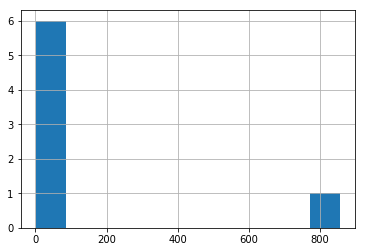

========================= DBLAB0101 =========================
5.940780141843971 9769.0 0.0
under 2 minutes delay count: 2256
under 5 minutes delay count: 196
under 30 minutes delay count: 365
under 60 minutes delay count: 1
under 120 minutes delay count: 0
under 180 minutes delay count: 0
under 360 minutes delay count: 1
under inf minutes delay count: 1
[2256, 2452, 2817, 2818, 2818, 2818, 2819, 2820] / normal status rate: 80.0 %


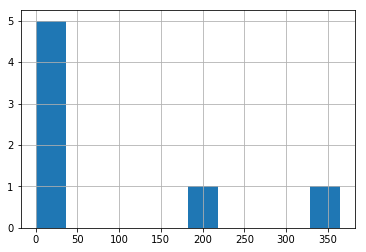

========================= DBLAB0102 =========================
2.0256762054096433 1752.0 0.0
under 2 minutes delay count: 5045
under 5 minutes delay count: 44
under 30 minutes delay count: 3
under 60 minutes delay count: 0
under 120 minutes delay count: 2
under 180 minutes delay count: 0
under 360 minutes delay count: 4
under inf minutes delay count: 4
[5045, 5089, 5092, 5092, 5094, 5094, 5098, 5102] / normal status rate: 98.88279106232851 %


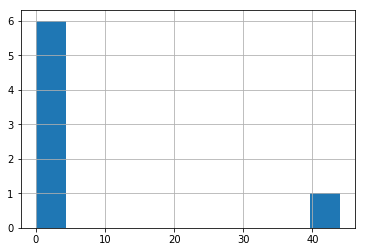

========================= DBLAB0103 =========================
1.2636058499160874 238.0 0.0
under 2 minutes delay count: 8192
under 5 minutes delay count: 121
under 30 minutes delay count: 6
under 60 minutes delay count: 14
under 120 minutes delay count: 5
under 180 minutes delay count: 1
under 360 minutes delay count: 3
under inf minutes delay count: 0
[8192, 8313, 8319, 8333, 8338, 8339, 8342, 8342] / normal status rate: 98.20187005514265 %


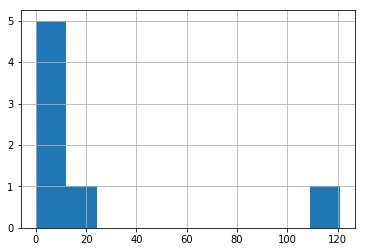

========================= DBLAB0201 =========================
2.740042372881356 6825.0 0.0
under 2 minutes delay count: 4712
under 5 minutes delay count: 2
under 30 minutes delay count: 0
under 60 minutes delay count: 2
under 120 minutes delay count: 0
under 180 minutes delay count: 0
under 360 minutes delay count: 1
under inf minutes delay count: 3
[4712, 4714, 4714, 4716, 4716, 4716, 4717, 4720] / normal status rate: 99.83050847457628 %


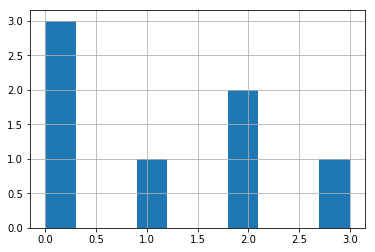

========================= DBLAB0301 =========================
1.35284373274434 336.0 0.0
under 2 minutes delay count: 1792
under 5 minutes delay count: 11
under 30 minutes delay count: 5
under 60 minutes delay count: 0
under 120 minutes delay count: 1
under 180 minutes delay count: 0
under 360 minutes delay count: 2
under inf minutes delay count: 0
[1792, 1803, 1808, 1808, 1809, 1809, 1811, 1811] / normal status rate: 98.95085588072888 %


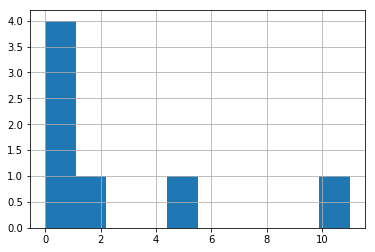

In [23]:
# delay count

delay_range = [2, 5, 30, 60, 120, 180, 360, np.inf] #delay range in minutes

for key, data in dataset.items():
    print(f"========================= {key} =========================")
    df = data['pos']
    df['delay_minute'] = df['delay'].map(lambda x: x.total_seconds() // 60 )
    print(df['delay_minute'].mean(), df['delay_minute'].max(), df['delay_minute'].min())    
    count_bucket = []
    for r in delay_range:
        count_bucket.append(len(df[df['delay_minute'] < r].index))
        if len(count_bucket) == 1:
            print(f"under {r} minutes delay count: {count_bucket[-1]}")
        else:
            print(f"under {r} minutes delay count: {count_bucket[-1] - count_bucket[-2]}")    
    print(f"{count_bucket} / normal status rate: {count_bucket[0] / count_bucket[-1] * 100} %")
    
    # show count hist except normal location data (< 2 mim)
    s = pd.Series(count_bucket)
    s = s.diff()        
    s = s.drop(s.index[0])    
    s.hist()
    plt.show()

<p>It seems that most of data were sent properly. (< 2 min) <br>
    There are few the 30 min gaps, becuase of 20 min test of DBLAB0101. So, it is intentional.<br>
    Let's see the other big gaps in detail.
    </p>

In [24]:
dataset

{'HCICG01': {'pos':           name      id  deviceid              servertime          devicetime  \
  0      HCICG01  301568        54 2019-01-24 16:35:26.735 2019-01-17 18:27:48   
  1      HCICG01  301569        54 2019-01-24 16:35:26.829 2019-01-17 18:28:55   
  2      HCICG01  301570        54 2019-01-24 16:35:26.856 2019-01-17 18:31:01   
  3      HCICG01  301571        54 2019-01-24 16:35:26.882 2019-01-17 18:32:05   
  4      HCICG01  301572        54 2019-01-24 16:35:26.909 2019-01-17 18:33:45   
  5      HCICG01  301573        54 2019-01-24 16:35:26.935 2019-01-17 18:35:13   
  6      HCICG01  301574        54 2019-01-24 16:35:26.960 2019-01-17 18:36:13   
  7      HCICG01  301575        54 2019-01-24 16:35:26.989 2019-01-17 18:37:14   
  8      HCICG01  301576        54 2019-01-24 16:35:27.018 2019-01-17 18:39:17   
  9      HCICG01  301577        54 2019-01-24 16:35:27.056 2019-01-17 18:41:16   
  10     HCICG01  301578        54 2019-01-24 16:35:27.098 2019-01-17 18:42:24  

In [25]:
# when do we have big gaps?

def pick_gaps(df, r_min, r_max):
    name = f'{r_min}_to_{r_max}'
    gaps = {
        'name': name,
        'min': r_min,
        'max': r_max,
        
    }
    print(f"Culling {r_min} - {r_max} min")    
    
    df['delay_minute'] = df['delay'].map(lambda x: x.seconds/60)
    
    # culling gaps
    gap_list = list(df[df['delay_minute'].between(r_min, r_max)].index)
    print(gap_list)
    gaps['list'] = cull_gap_surroundings(df, gap_list)
    return gaps

In [26]:
#culling rows before and after gaps
def cull_gap_surroundings(df, gaps, around=2):           
    surroundings = []    
    for center in gaps:                
        rows = df[(center - around) : (center + around + 1)]
        '''
        TODO: Out of bound control
        slice doesn't raise Out of bound exception
        but it didn't not return when out of bound slice
        For now, works fine with our data
        '''
        surroundings.append({
            'gap': center,
            'rows': rows
        })   
    return surroundings        

In [27]:
for key, data in dataset.items():
    data['gaps'] = []
    for i, r in enumerate(reversed(delay_range[:-1])):  #We'll look up big gaps first
    #for i, r in enumerate(delay_range[1:]): #small gaps first
        pos = data['pos']        
        data['gaps'].append(pick_gaps(pos, r, delay_range[-(i+1)]))

Culling 360 - inf min
[7704]
Culling 180 - 360 min
[335]
Culling 120 - 180 min
[5212]
Culling 60 - 120 min
[401, 12262]
Culling 30 - 60 min
[4378, 5211, 8583, 11962]
Culling 5 - 30 min
[2609, 3131, 3313, 4519, 5012, 5100, 6240, 6922, 7170, 7410, 7768, 9191, 12188]
Culling 2 - 5 min
[2, 8, 15, 18, 31, 64, 69, 95, 109, 123, 138, 174, 306, 350, 361, 375, 388, 412, 417, 447, 457, 458, 462, 471, 474, 492, 537, 620, 653, 658, 663, 671, 679, 688, 691, 705, 707, 720, 740, 745, 747, 766, 769, 789, 791, 795, 816, 837, 840, 847, 870, 872, 873, 888, 900, 931, 950, 966, 991, 1000, 1019, 1020, 1028, 1048, 1104, 1115, 1138, 1146, 1160, 1173, 1187, 1212, 1231, 1239, 1242, 1250, 1251, 1259, 1262, 1280, 1288, 1296, 1298, 1372, 1388, 1391, 1425, 1456, 1468, 1481, 1499, 1502, 1533, 1560, 1570, 1619, 1620, 1669, 1724, 1737, 1738, 1794, 1800, 1815, 1844, 1851, 1861, 1869, 1871, 1876, 1890, 1897, 1914, 1916, 1948, 1951, 1952, 1953, 1988, 1995, 2018, 2034, 2044, 2069, 2075, 2093, 2133, 2136, 2168, 2196, 2201,

[71, 3774, 4217]
Culling 180 - 360 min
[357, 791, 1738, 2771, 5008]
Culling 120 - 180 min
[]
Culling 60 - 120 min
[119, 577]
Culling 30 - 60 min
[]
Culling 5 - 30 min
[69, 1739, 2772]
Culling 2 - 5 min
[72, 92, 95, 96, 97, 100, 371, 372, 375, 376, 377, 408, 793, 812, 815, 817, 820, 1272, 1273, 1277, 1278, 1760, 1763, 1764, 1765, 2303, 2307, 2308, 2351, 2790, 2793, 3295, 3298, 3299, 3300, 3332, 3348, 3787, 3799, 4292, 5020, 5023, 5025, 5028]
Culling 360 - inf min
[]
Culling 180 - 360 min
[4513, 4840, 6168]
Culling 120 - 180 min
[4853]
Culling 60 - 120 min
[1993, 4496, 4823, 4991, 6157]
Culling 30 - 60 min
[1209, 1985, 2008, 2076, 4488, 4816, 4916, 4985, 5002, 5298, 5995, 6150, 6259, 7318]
Culling 5 - 30 min
[1216, 2083, 4582, 4917, 4923, 6266]
Culling 2 - 5 min
[2, 4, 7, 39, 425, 504, 539, 573, 641, 652, 675, 926, 1037, 1132, 1151, 1262, 1387, 1437, 1600, 1726, 1793, 1849, 1884, 1894, 1966, 2144, 2205, 2459, 2660, 2674, 2777, 2850, 2870, 2906, 2940, 3023, 3409, 3438, 3620, 3704, 3740, 3

<h3>Looking into the gaps</h3>
<p>We are looking into DBLAB0102 and DBLAB0103 first. They are always carried together, and turned on 24 hours except 1 day. So, they're the most controled test set.</p>

In [28]:
for i in range(len(delay_range) - 1):
    print(dataset['DBLAB0102']['gaps'][i]['name'], len(dataset['DBLAB0102']['gaps'][i]['list']), len(dataset['DBLAB0103']['gaps'][i]['list']))

360_to_inf 3 0
180_to_360 5 3
120_to_180 0 1
60_to_120 2 5
30_to_60 0 14
5_to_30 3 6
2_to_5 44 121


In [29]:
d1_it = iter(dataset['DBLAB0102']['gaps'])
d2_it = iter(dataset['DBLAB0103']['gaps'])

In [31]:
# 360_to_inf 3 0
gaps1, gaps2 = next(d1_it), next(d2_it)

In [32]:
it = iter(gaps1['list'])
for i in it:
    print(i)

{'gap': 71, 'rows':          name      id  deviceid              servertime          devicetime  \
69  DBLAB0102  294576        51 2019-01-20 23:22:18.916 2019-01-20 23:21:48   
70  DBLAB0102  294577        51 2019-01-20 23:22:57.473 2019-01-20 23:22:57   
71  DBLAB0102  295095        51 2019-01-21 08:26:04.552 2019-01-21 08:21:07   
72  DBLAB0102  295096        51 2019-01-21 08:26:04.708 2019-01-21 08:26:04   
73  DBLAB0102  295098        51 2019-01-21 08:27:37.985 2019-01-21 08:27:37   

               fixtime   latitude   longitude   altitude  speed  course  \
69 2019-01-20 23:21:48  37.415326  126.879808  41.987000    0.0     0.0   
70 2019-01-20 23:22:57  37.415328  126.879844  41.700363    0.0     0.0   
71 2019-01-21 08:21:07  37.416503  126.884238  37.956139    0.0     0.0   
72 2019-01-21 08:26:04  37.445378  126.895622  37.956139    0.0     0.0   
73 2019-01-21 08:27:37  37.449017  126.895454  37.956139    0.0     0.0   

    accuracy  battery_level     dist  total_dist  moti

<h5>DBLAB0102</h5>
<p>
71: Reported pause. It is not a bug.<br>
3774: First day out from home. Awaken from sleep mode.<br>
4217: Same as above.
    </p>

In [33]:
#180_to_360 5 3

gaps1, gaps2 = next(d1_it), next(d2_it)

In [34]:
it = iter(gaps1['list'])
for i in it:
    print(i)

{'gap': 357, 'rows':           name      id  deviceid              servertime          devicetime  \
355  DBLAB0102  295754        51 2019-01-21 14:55:10.085 2019-01-21 14:55:09   
356  DBLAB0102  295756        51 2019-01-21 14:56:11.084 2019-01-21 14:56:10   
357  DBLAB0102  295946        51 2019-01-21 18:11:50.026 2019-01-21 18:11:43   
358  DBLAB0102  295948        51 2019-01-21 18:12:45.090 2019-01-21 18:12:44   
359  DBLAB0102  295950        51 2019-01-21 18:14:38.851 2019-01-21 18:13:45   

                fixtime   latitude   longitude   altitude  speed  course  \
355 2019-01-21 14:55:09  37.555125  127.050063  36.349976    0.0     0.0   
356 2019-01-21 14:56:10  37.555125  127.050063  36.684875    0.0     0.0   
357 2019-01-21 18:11:43  37.555152  127.050041  26.199286    0.0     0.0   
358 2019-01-21 18:12:44  37.555191  127.050067  26.273005    0.0     0.0   
359 2019-01-21 18:13:45  37.555550  127.049522  31.130377    0.0     0.0   

     accuracy  battery_level   dist  tota

<h5>DBLAB0102</h5>
<p>
357: Turned off. Low battery.<br>
791: First day out from home. Awaken from sleep mode.<br>
1739: iPhone alerted the app consume too much battery. It seems to block the client process <br>
    I noticed and confirmed at 01-24. ("입력 허가" in Korean) (I didn't unlock the test phone. I Just charged and carried it) <br>
2771: Same as 791.
    </p>


In [35]:
it = iter(gaps2['list'])
for i in it:
    print(i)

{'gap': 4513, 'rows':            name      id  deviceid              servertime          devicetime  \
4511  DBLAB0103  309935        52 2019-01-24 16:46:59.156 2019-01-24 13:31:04   
4512  DBLAB0103  309933        52 2019-01-24 16:46:43.438 2019-01-24 13:31:04   
4513  DBLAB0103  309934        52 2019-01-24 16:46:43.526 2019-01-24 16:46:06   
4514  DBLAB0103  309937        52 2019-01-24 16:47:34.542 2019-01-24 16:47:28   
4515  DBLAB0103  309940        52 2019-01-24 16:48:37.972 2019-01-24 16:48:31   

                 fixtime   latitude   longitude   altitude  speed  course  \
4511 2019-01-24 13:31:04  37.555780  127.049504  72.699997    0.0     0.0   
4512 2019-01-24 13:31:04  37.555780  127.049504  72.699997    0.0     0.0   
4513 2019-01-24 16:46:06  37.555769  127.049499  72.699997    0.0     0.0   
4514 2019-01-24 16:47:28  37.555765  127.049524  72.699997    0.0     0.0   
4515 2019-01-24 16:48:31  37.555763  127.049526  72.699997    0.0     0.0   

       accuracy  battery_lev

In [ ]:
<h5>DBLAB0103</h5>
<p>
357: Turned off. Low battery.<br>
791: First day out from home. Awaken from sleep mode.<br>
1739: iPhone alerted the app consume too much battery. It seems to block the client process <br>
    I noticed and confirmed at 01-24. ("입력 허가" in Korean) (I didn't unlock the test phone. I Just charged and carried it) <br>
2771: Same as 791.
    </p>


In [105]:
gap = next(gap1)
gap

{'gap': 357,
 'rows':           name      id  deviceid              servertime          devicetime  \
 355  DBLAB0102  295754        51 2019-01-21 14:55:10.085 2019-01-21 14:55:09   
 356  DBLAB0102  295756        51 2019-01-21 14:56:11.084 2019-01-21 14:56:10   
 357  DBLAB0102  295946        51 2019-01-21 18:11:50.026 2019-01-21 18:11:43   
 358  DBLAB0102  295948        51 2019-01-21 18:12:45.090 2019-01-21 18:12:44   
 359  DBLAB0102  295950        51 2019-01-21 18:14:38.851 2019-01-21 18:13:45   
 
                 fixtime   latitude   longitude   altitude  speed  course  \
 355 2019-01-21 14:55:09  37.555125  127.050063  36.349976    0.0     0.0   
 356 2019-01-21 14:56:10  37.555125  127.050063  36.684875    0.0     0.0   
 357 2019-01-21 18:11:43  37.555152  127.050041  26.199286    0.0     0.0   
 358 2019-01-21 18:12:44  37.555191  127.050067  26.273005    0.0     0.0   
 359 2019-01-21 18:13:45  37.555550  127.049522  31.130377    0.0     0.0   
 
      accuracy  battery_lev

In [106]:
gap = next(gap1)
gap

{'gap': 791,
 'rows':           name      id  deviceid              servertime          devicetime  \
 789  DBLAB0102  297178        51 2019-01-22 08:57:05.475 2019-01-22 03:08:24   
 790  DBLAB0102  296841        51 2019-01-22 03:08:24.166 2019-01-22 03:08:24   
 791  DBLAB0102  297186        51 2019-01-22 08:57:07.915 2019-01-22 08:24:02   
 792  DBLAB0102  297191        51 2019-01-22 08:57:11.347 2019-01-22 08:25:06   
 793  DBLAB0102  297195        51 2019-01-22 08:57:12.648 2019-01-22 08:27:09   
 
                 fixtime   latitude   longitude   altitude  speed  course  \
 789 2019-01-22 03:08:24  37.415295  126.879858  41.885933    0.0     0.0   
 790 2019-01-22 03:08:24  37.415295  126.879858  41.885933    0.0     0.0   
 791 2019-01-22 08:24:02  37.416994  126.884924  26.752476    0.0     0.0   
 792 2019-01-22 08:25:06  37.417065  126.884946  26.610842    0.0     0.0   
 793 2019-01-22 08:27:09  37.417113  126.885125  26.610842    0.0     0.0   
 
      accuracy  battery_lev

DBLAB0102 / 791: #790 in indoor (tester's home) #791 in outdoor (nearby station)

In [107]:
gap = next(gap1)
gap

{'gap': 1738,
 'rows':            name      id  deviceid              servertime          devicetime  \
 1736  DBLAB0102  300617        51 2019-01-24 08:28:23.978 2019-01-23 03:05:31   
 1737  DBLAB0102  298897        51 2019-01-23 03:05:32.082 2019-01-23 03:05:31   
 1738  DBLAB0102  300618        51 2019-01-24 08:28:24.149 2019-01-24 08:18:10   
 1739  DBLAB0102  300619        51 2019-01-24 08:28:24.322 2019-01-24 08:27:53   
 1740  DBLAB0102  300621        51 2019-01-24 08:28:55.035 2019-01-24 08:28:54   
 
                  fixtime   latitude   longitude   altitude  speed  course  \
 1736 2019-01-23 03:05:31  37.415354  126.879795  42.016788    0.0     0.0   
 1737 2019-01-23 03:05:31  37.415354  126.879795  42.016788    0.0     0.0   
 1738 2019-01-24 08:18:10  37.415651  126.881761  30.920000    0.0     0.0   
 1739 2019-01-24 08:27:53  37.454902  126.895622  42.854919    0.0     0.0   
 1740 2019-01-24 08:28:54  37.472633  126.886721  20.895157    0.0     0.0   
 
       accurac

DBLAB0102 / 1738: #1737 in indoor, midnight. #1739 in outdoor (nearby roadside)
Same as #791

In [108]:
gap = next(gap1)
gap

{'gap': 2771,
 'rows':            name      id  deviceid              servertime          devicetime  \
 2769  DBLAB0102  311987        51 2019-01-25 08:18:02.565 2019-01-25 03:11:44   
 2770  DBLAB0102  311671        51 2019-01-25 03:11:44.471 2019-01-25 03:11:44   
 2771  DBLAB0102  311988        51 2019-01-25 08:18:03.184 2019-01-25 08:03:03   
 2772  DBLAB0102  311989        51 2019-01-25 08:18:03.936 2019-01-25 08:18:02   
 2773  DBLAB0102  311991        51 2019-01-25 08:19:07.823 2019-01-25 08:19:07   
 
                  fixtime   latitude   longitude   altitude  speed  course  \
 2769 2019-01-25 03:11:44  37.415328  126.879913  41.875500    0.0     0.0   
 2770 2019-01-25 03:11:44  37.415328  126.879913  41.875500    0.0     0.0   
 2771 2019-01-25 08:03:03  37.415278  126.880124  40.617088    0.0     0.0   
 2772 2019-01-25 08:18:02  37.496270  126.878295  39.268002    0.0     0.0   
 2773 2019-01-25 08:19:07  37.510067  126.894476  26.642525    0.0     0.0   
 
       accurac

DBLAB0102 / 2771: Same as above

<h5>Summmary on DBLAB0102 (180_to_360 min)</h5>
It seems to be a kind of sleep mode activated. As I know, Traccar doesn't have sleep mode or idle mode. It might be iOS' work

In [109]:
gap = next(gap2)
gap

{'gap': 4513,
 'rows':            name      id  deviceid              servertime          devicetime  \
 4511  DBLAB0103  309933        52 2019-01-24 16:46:43.438 2019-01-24 13:31:04   
 4512  DBLAB0103  309935        52 2019-01-24 16:46:59.156 2019-01-24 13:31:04   
 4513  DBLAB0103  309934        52 2019-01-24 16:46:43.526 2019-01-24 16:46:06   
 4514  DBLAB0103  309937        52 2019-01-24 16:47:34.542 2019-01-24 16:47:28   
 4515  DBLAB0103  309940        52 2019-01-24 16:48:37.972 2019-01-24 16:48:31   
 
                  fixtime   latitude   longitude   altitude  speed  course  \
 4511 2019-01-24 13:31:04  37.555780  127.049504  72.699997    0.0     0.0   
 4512 2019-01-24 13:31:04  37.555780  127.049504  72.699997    0.0     0.0   
 4513 2019-01-24 16:46:06  37.555769  127.049499  72.699997    0.0     0.0   
 4514 2019-01-24 16:47:28  37.555765  127.049524  72.699997    0.0     0.0   
 4515 2019-01-24 16:48:31  37.555763  127.049526  72.699997    0.0     0.0   
 
        accura

DBLAB0103 / 4513: Same place (testers workspace), 

In [110]:
gap = next(gap2)
gap

{'gap': 4840,
 'rows':            name      id  deviceid              servertime          devicetime  \
 4838  DBLAB0103  311471        52 2019-01-25 01:26:14.145 2019-01-25 01:26:13   
 4839  DBLAB0103  311800        52 2019-01-25 05:25:38.731 2019-01-25 01:27:13   
 4840  DBLAB0103  311801        52 2019-01-25 05:25:38.788 2019-01-25 05:25:26   
 4841  DBLAB0103  311803        52 2019-01-25 05:26:49.027 2019-01-25 05:26:48   
 4842  DBLAB0103  311805        52 2019-01-25 05:27:49.906 2019-01-25 05:27:48   
 
                  fixtime   latitude   longitude    altitude  speed  course  \
 4838 2019-01-25 01:26:13  37.415693  126.879573  112.699997    0.0     0.0   
 4839 2019-01-25 01:27:13  37.415682  126.879572  112.699997    0.0     0.0   
 4840 2019-01-25 05:25:26  37.415682  126.879572  112.699997    0.0     0.0   
 4841 2019-01-25 05:26:48  37.415692  126.879573  112.699997    0.0     0.0   
 4842 2019-01-25 05:27:48  37.415692  126.879573  112.699997    0.0     0.0   
 
       a

DBLAB0103 / 4840: Testers home, midnight

<h5>Summmary on Long gaps (180_to_360 min)</h5>
<p>The experiment of DBLAB0102 and 0103 had begun Monday, 21st. iPhone's long gap (DBLAB0102), It seems to be a kind of sleep mode activated. As I know, Traccar doesn't have sleep mode or idle mode. It might be iOS' work.</p>
<p>As I know, energy-saving mode of most Samsung galaxy smartphone's turns on three days after the last use of the app on foreground. I have recorded when I turned on the client at first, but I didn't when I check the client on foregoround -- that makes the energy-saving mode timer reset.</p>
<p>So far, I guess the long gaps (> 3 hours) usaually caused by sleep mode or energy saving mode of smartphones.
    </p>

In [119]:
# 120_to_180 0 1

gaps1, gaps2 = next(d1_it), next(d2_it)
gap1, gap2 = iter(gaps1['list']), iter(gaps2['list'])

In [80]:
gap = next(gap2)
gap

{'gap': 4853,
 'rows':            name      id  deviceid              servertime          devicetime  \
 4851  DBLAB0103  311824        52 2019-01-25 05:37:00.448 2019-01-25 05:36:59   
 4852  DBLAB0103  311826        52 2019-01-25 05:38:00.906 2019-01-25 05:37:59   
 4853  DBLAB0103  311941        52 2019-01-25 07:59:11.013 2019-01-25 07:59:09   
 4854  DBLAB0103  311942        52 2019-01-25 08:01:28.639 2019-01-25 08:00:54   
 4855  DBLAB0103  311943        52 2019-01-25 08:01:56.305 2019-01-25 08:01:55   
 
                  fixtime   latitude   longitude    altitude  speed  course  \
 4851 2019-01-25 05:36:59  37.415687  126.879580  112.699997    0.0     0.0   
 4852 2019-01-25 05:37:59  37.415687  126.879580  112.699997    0.0     0.0   
 4853 2019-01-25 07:59:09  37.415687  126.879580  112.699997    0.0     0.0   
 4854 2019-01-25 08:00:54  37.415664  126.879561    0.000000    0.0     0.0   
 4855 2019-01-25 08:01:55  37.415664  126.879561    0.000000    0.0     0.0   
 
        

DBLAB0103 / 4843: Testers home to nearby roadside, morning

In [120]:
# 60_to_120 2 5

gaps1, gaps2 = next(d1_it), next(d2_it)
gap1, gap2 = iter(gaps1['list']), iter(gaps2['list'])

In [121]:
gap = next(gap1)
gap

{'gap': 119,
 'rows':           name      id  deviceid              servertime          devicetime  \
 117  DBLAB0102  295198        51 2019-01-21 09:27:28.768 2019-01-21 09:27:28   
 118  DBLAB0102  295269        51 2019-01-21 10:40:36.633 2019-01-21 09:27:28   
 119  DBLAB0102  295270        51 2019-01-21 10:40:36.915 2019-01-21 10:40:35   
 120  DBLAB0102  295272        51 2019-01-21 10:41:40.577 2019-01-21 10:41:40   
 121  DBLAB0102  295274        51 2019-01-21 10:42:45.589 2019-01-21 10:42:45   
 
                 fixtime   latitude   longitude   altitude  speed  course  \
 117 2019-01-21 09:27:28  37.555067  127.050128  30.180229    0.0     0.0   
 118 2019-01-21 09:27:28  37.555067  127.050128  30.180229    0.0     0.0   
 119 2019-01-21 10:40:35  37.555115  127.050077  31.183516    0.0     0.0   
 120 2019-01-21 10:41:40  37.555111  127.050112  30.409775    0.0     0.0   
 121 2019-01-21 10:42:45  37.555097  127.050112  30.041840    0.0     0.0   
 
      accuracy  battery_lev

DBLAB0102 / 119: In Workspace, large battery gaps

In [122]:
gap = next(gap1)
gap

{'gap': 577,
 'rows':           name      id  deviceid              servertime          devicetime  \
 575  DBLAB0102  296335        51 2019-01-21 22:09:12.593 2019-01-21 22:09:12   
 576  DBLAB0102  296337        51 2019-01-21 22:10:12.620 2019-01-21 22:10:12   
 577  DBLAB0102  296420        51 2019-01-21 23:34:31.972 2019-01-21 23:34:31   
 578  DBLAB0102  296422        51 2019-01-21 23:35:42.936 2019-01-21 23:35:42   
 579  DBLAB0102  296424        51 2019-01-21 23:36:42.959 2019-01-21 23:36:42   
 
                 fixtime   latitude   longitude   altitude  speed  course  \
 575 2019-01-21 22:09:12  37.415359  126.879750  41.983135    0.0     0.0   
 576 2019-01-21 22:10:12  37.415359  126.879750  41.988945    0.0     0.0   
 577 2019-01-21 23:34:31  37.415334  126.879666  42.806885    0.0     0.0   
 578 2019-01-21 23:35:42  37.415333  126.879672  42.812878    0.0     0.0   
 579 2019-01-21 23:36:42  37.415334  126.879666  42.925442    0.0     0.0   
 
      accuracy  battery_lev

DBLAB0102 / 577: In home, large battery gaps

In [124]:
gap = next(gap2)
gap

{'gap': 1993,
 'rows':            name      id  deviceid              servertime          devicetime  \
 1991  DBLAB0103  297453        52 2019-01-22 11:52:45.791 2019-01-22 11:52:41   
 1992  DBLAB0103  297530        52 2019-01-22 13:31:37.311 2019-01-22 11:53:41   
 1993  DBLAB0103  297531        52 2019-01-22 13:31:37.359 2019-01-22 13:31:20   
 1994  DBLAB0103  297533        52 2019-01-22 13:32:47.753 2019-01-22 13:32:43   
 1995  DBLAB0103  297534        52 2019-01-22 13:33:47.833 2019-01-22 13:33:43   
 
                  fixtime   latitude   longitude   altitude  speed  course  \
 1991 2019-01-22 11:52:41  37.555761  127.049516  72.699997    0.0     0.0   
 1992 2019-01-22 11:53:41  37.555761  127.049516  72.699997    0.0     0.0   
 1993 2019-01-22 13:31:20  37.555767  127.049529  72.699997    0.0     0.0   
 1994 2019-01-22 13:32:43  37.555768  127.049528  72.800003    0.0     0.0   
 1995 2019-01-22 13:33:43  37.555768  127.049528  72.800003    0.0     0.0   
 
       accurac

DBLAB0103 / 1993: In home, large battery gaps

In [125]:
gap = next(gap2)
gap

{'gap': 4496,
 'rows':            name      id  deviceid              servertime          devicetime  \
 4494  DBLAB0103  300961        52 2019-01-24 11:25:18.380 2019-01-24 11:25:12   
 4495  DBLAB0103  300964        52 2019-01-24 11:26:19.294 2019-01-24 11:26:13   
 4496  DBLAB0103  301171        52 2019-01-24 13:15:30.211 2019-01-24 13:15:24   
 4497  DBLAB0103  301174        52 2019-01-24 13:16:53.391 2019-01-24 13:16:47   
 4498  DBLAB0103  301177        52 2019-01-24 13:17:54.302 2019-01-24 13:17:48   
 
                  fixtime   latitude   longitude   altitude  speed  course  \
 4494 2019-01-24 11:25:12  37.555763  127.049525  72.699997    0.0     0.0   
 4495 2019-01-24 11:26:13  37.555768  127.049518  72.800003    0.0     0.0   
 4496 2019-01-24 13:15:24  37.555768  127.049518  72.800003    0.0     0.0   
 4497 2019-01-24 13:16:47  37.555766  127.049514  72.800003    0.0     0.0   
 4498 2019-01-24 13:17:48  37.555770  127.049516  72.800003    0.0     0.0   
 
       accurac

DBLAB0103 / 4496: In workspace, same place

In [126]:
gap = next(gap2)
gap

{'gap': 4823,
 'rows':            name      id  deviceid              servertime          devicetime  \
 4821  DBLAB0103  311227        52 2019-01-24 23:24:10.484 2019-01-24 23:24:09   
 4822  DBLAB0103  311357        52 2019-01-25 01:10:46.586 2019-01-24 23:25:11   
 4823  DBLAB0103  311358        52 2019-01-25 01:10:46.657 2019-01-25 01:10:41   
 4824  DBLAB0103  311361        52 2019-01-25 01:12:07.144 2019-01-25 01:12:06   
 4825  DBLAB0103  311363        52 2019-01-25 01:13:07.145 2019-01-25 01:13:06   
 
                  fixtime   latitude   longitude    altitude  speed  course  \
 4821 2019-01-24 23:24:09  37.415692  126.879572  112.699997    0.0     0.0   
 4822 2019-01-24 23:25:11  37.415692  126.879573  112.699997    0.0     0.0   
 4823 2019-01-25 01:10:41  37.415692  126.879573  112.699997    0.0     0.0   
 4824 2019-01-25 01:12:06  37.415707  126.879577  112.699997    0.0     0.0   
 4825 2019-01-25 01:13:06  37.415707  126.879576  112.699997    0.0     0.0   
 
       a

DBLAB0103 / 4823: In home, same place. about 12 hours from previous gap.

In [127]:
gap = next(gap2)
gap

{'gap': 4991,
 'rows':            name      id  deviceid              servertime          devicetime  \
 4989  DBLAB0103  313620        52 2019-01-25 18:42:15.922 2019-01-25 12:25:55   
 4990  DBLAB0103  313621        52 2019-01-25 18:42:16.002 2019-01-25 12:27:00   
 4991  DBLAB0103  313622        52 2019-01-25 18:42:16.081 2019-01-25 14:24:37   
 4992  DBLAB0103  313623        52 2019-01-25 18:42:16.161 2019-01-25 14:26:03   
 4993  DBLAB0103  313624        52 2019-01-25 18:42:16.249 2019-01-25 14:27:06   
 
                  fixtime   latitude   longitude   altitude  speed  course  \
 4989 2019-01-25 12:25:55  37.555769  127.049529  72.699997    0.0     0.0   
 4990 2019-01-25 12:27:00  37.555769  127.049529  72.699997    0.0     0.0   
 4991 2019-01-25 14:24:37  37.555768  127.049528  72.800003    0.0     0.0   
 4992 2019-01-25 14:26:03  37.555763  127.049538  72.699997    0.0     0.0   
 4993 2019-01-25 14:27:06  37.555768  127.049528  72.699997    0.0     0.0   
 
       accurac

In [128]:
gap = next(gap2)
gap

{'gap': 6157,
 'rows':            name      id  deviceid              servertime          devicetime  \
 6155  DBLAB0103  316330        52 2019-01-26 13:28:30.133 2019-01-26 13:28:30   
 6156  DBLAB0103  316332        52 2019-01-26 13:29:30.904 2019-01-26 13:29:31   
 6157  DBLAB0103  316431        52 2019-01-26 15:24:46.569 2019-01-26 15:24:46   
 6158  DBLAB0103  316432        52 2019-01-26 15:26:10.000 2019-01-26 15:26:10   
 6159  DBLAB0103  316433        52 2019-01-26 15:27:10.241 2019-01-26 15:27:10   
 
                  fixtime   latitude   longitude    altitude  speed  course  \
 6155 2019-01-26 13:28:30  37.415682  126.879573  112.699997    0.0     0.0   
 6156 2019-01-26 13:29:31  37.415682  126.879573  112.699997    0.0     0.0   
 6157 2019-01-26 15:24:46  37.415682  126.879573  112.699997    0.0     0.0   
 6158 2019-01-26 15:26:10  37.415714  126.879588  112.699997    0.0     0.0   
 6159 2019-01-26 15:27:10  37.415708  126.879577  112.699997    0.0     0.0   
 
       a

<h5>Summmary on mid-range gaps (60_to_360 min)</h5>
<p>iPhone's gaps have showed when the battery has been going from a relatively low to a high</p>
<p>On the other hand, Android(Samsung Galaxy S5)'s gaps don't have relation with battery level. They usually appeared in the afternoon, indoor state. I need futher experiment.
    </p>

In [132]:
# 30_to_60 0 12

gaps1, gaps2 = next(d1_it), next(d2_it)
gap1, gap2 = iter(gaps1['list']), iter(gaps2['list'])

In [138]:
for i in gap2:
    print(i)

{'gap': 1209, 'rows':            name      id  deviceid              servertime          devicetime  \
1207  DBLAB0103  296193        52 2019-01-21 20:29:09.519 2019-01-21 20:29:05   
1208  DBLAB0103  296195        52 2019-01-21 20:30:10.417 2019-01-21 20:30:06   
1209  DBLAB0103  296242        52 2019-01-21 21:17:30.382 2019-01-21 21:17:25   
1210  DBLAB0103  296244        52 2019-01-21 21:18:29.856 2019-01-21 21:18:26   
1211  DBLAB0103  296246        52 2019-01-21 21:19:31.596 2019-01-21 21:19:27   

                 fixtime   latitude  longitude    altitude  speed  course  \
1207 2019-01-21 20:29:05  37.415601  126.87955  112.099998    0.0     0.0   
1208 2019-01-21 20:30:06  37.415601  126.87955  112.099998    0.0     0.0   
1209 2019-01-21 21:17:25  37.415601  126.87955  112.099998    0.0     0.0   
1210 2019-01-21 21:18:26  37.415601  126.87955  112.099998    0.0     0.0   
1211 2019-01-21 21:19:27  37.415601  126.87955  112.099998    0.0     0.0   

      accuracy  battery_leve

<h5>Summmary on short gaps (30 - 60 min)</h5>
<p>iPhone's gaps have showed when the battery has been going from a relatively low to a high</p>
<p>On the other hand, Android(Samsung Galaxy S5)'s gaps don't have relation with battery level. They usually appeared in the afternoon, indoor state. I need futher experiment.
    </p>

In [139]:
# 5_to_30 3 5

gaps1, gaps2 = next(d1_it), next(d2_it)

In [146]:
it = iter(gaps1['list'])
for i in it:
    print(i)

{'gap': 69, 'rows':          name      id  deviceid              servertime          devicetime  \
67  DBLAB0102  294574        51 2019-01-20 23:01:41.189 2019-01-20 23:01:41   
68  DBLAB0102  294575        51 2019-01-20 23:02:41.201 2019-01-20 23:02:41   
69  DBLAB0102  294576        51 2019-01-20 23:22:18.916 2019-01-20 23:21:48   
70  DBLAB0102  294577        51 2019-01-20 23:22:57.473 2019-01-20 23:22:57   
71  DBLAB0102  295095        51 2019-01-21 08:26:04.552 2019-01-21 08:21:07   

               fixtime   latitude   longitude   altitude  speed  course  \
67 2019-01-20 23:01:41  37.415283  126.879879  41.144550    0.0     0.0   
68 2019-01-20 23:02:41  37.415282  126.879879  41.100925    0.0     0.0   
69 2019-01-20 23:21:48  37.415326  126.879808  41.987000    0.0     0.0   
70 2019-01-20 23:22:57  37.415328  126.879844  41.700363    0.0     0.0   
71 2019-01-21 08:21:07  37.416503  126.884238  37.956139    0.0     0.0   

    accuracy  battery_level    dist  total_dist  motio

In [189]:
df = copy.deepcopy(dataset['DBLAB0102']['pos'])
df.drop(['delay', 'delay_minute'], axis=1, inplace=True)
#df['delay'] = df['devicetime'].diff()
df = df[1735:1741]
df['delay'] = df['devicetime'].diff()
df['delay_minute'] = df['delay'].map(lambda x : x.total_seconds() // 60 )
df

,name,id,deviceid,servertime,devicetime,fixtime,latitude,longitude,altitude,speed,course,accuracy,battery_level,dist,total_dist,motion,delay,delay_minute
1735,DBLAB0102,298895,51,2019-01-23 03:04:32.072,2019-01-23 03:04:31,2019-01-23 03:04:31,37.415341,126.879990,42.153069,0.0,0.0,0.0,100.0,1.61,129248.69,False,NaT,NaN
1736,DBLAB0102,300617,51,2019-01-24 08:28:23.978,2019-01-23 03:05:31,2019-01-23 03:05:31,37.415354,126.879795,42.016788,0.0,0.0,0.0,100.0,0.00,129265.99,False,0 days 00:01:00,1.0
1737,DBLAB0102,298897,51,2019-01-23 03:05:32.082,2019-01-23 03:05:31,2019-01-23 03:05:31,37.415354,126.879795,42.016788,0.0,0.0,0.0,100.0,17.30,129265.99,False,0 days 00:00:00,0.0
1738,DBLAB0102,300618,51,2019-01-24 08:28:24.149,2019-01-24 08:18:10,2019-01-24 08:18:10,37.415651,126.881761,30.920000,0.0,0.0,0.0,98.0,176.94,129442.93,False,1 days 05:12:39,1752.0
1739,DBLAB0102,300619,51,2019-01-24 08:28:24.322,2019-01-24 08:27:53,2019-01-24 08:27:53,37.454902,126.895622,42.854919,0.0,0.0,0.0,98.0,4537.93,133980.86,False,0 days 00:09:43,9.0
1740,DBLAB0102,300621,51,2019-01-24 08:28:55.035,2019-01-24 08:28:54,2019-01-24 08:28:54,37.472633,126.886721,20.895157,0.0,0.0,0.0,98.0,2124.73,136105.59,False,0 days 00:01:01,1.0


In [28]:
# day iteration test
'''
start_date, end_date = period['DBLAB0103']['start'], period['DBLAB0103']['end']
print(start_date, end_date)
days = []
for single_date in daterange(start_date, end_date):
    days.append(single_date.replace(hour=0, minute=0, second=0))
print(days)
'''

"\nstart_date, end_date = period['DBLAB0103']['start'], period['DBLAB0103']['end']\nprint(start_date, end_date)\ndays = []\nfor single_date in daterange(start_date, end_date):\n    days.append(single_date.replace(hour=0, minute=0, second=0))\nprint(days)\n"

In [29]:
# delay mean by days
'''
for user in users['name']:
    print(f"========================={user}=========================")
    for single_date in daterange(period[user]['start'], period[user]['end']):
        today = single_date.replace(hour=0, minute=0, second=0)
        tomorrow  = today + timedelta(days=1)
        print(f"DAY {today} - {tomorrow}")        
        
        df = pos[user]        
        pos_by_day = df[(df['devicetime'] >= today) & (df['devicetime'] < tomorrow)]
        print(pos_by_day[view_time].head(5))
        if pos_by_day.shape[0] == 0:
            continue
        
        print("Delays")        
        print("mean", pos_by_day['delay'].mean())   
        print("max", pos_by_day['delay'].max(), pos_by_day['delay'].idxmax(), pos_by_day.loc[[pos_by_day['delay'].idxmax()]])   
        print("min", pos_by_day['delay'].min())   
        print()
'''

'\nfor user in users[\'name\']:\n    print(f"========================={user}=========================")\n    for single_date in daterange(period[user][\'start\'], period[user][\'end\']):\n        today = single_date.replace(hour=0, minute=0, second=0)\n        tomorrow  = today + timedelta(days=1)\n        print(f"DAY {today} - {tomorrow}")        \n        \n        df = pos[user]        \n        pos_by_day = df[(df[\'devicetime\'] >= today) & (df[\'devicetime\'] < tomorrow)]\n        print(pos_by_day[view_time].head(5))\n        if pos_by_day.shape[0] == 0:\n            continue\n        \n        print("Delays")        \n        print("mean", pos_by_day[\'delay\'].mean())   \n        print("max", pos_by_day[\'delay\'].max(), pos_by_day[\'delay\'].idxmax(), pos_by_day.loc[[pos_by_day[\'delay\'].idxmax()]])   \n        print("min", pos_by_day[\'delay\'].min())   \n        print()\n'